# *Predicting house prices: A regression example*

The two previous notebooks were considered classification problems, where the goal is to predict a single discrete label of an input data point. In this notebook, we will look into another common problem in machine learning, called *regression*. 

*Regression* consists of predicting a continuous value instead of a discrete label: for example, predicting the temperature tomorrow, given meteorological data or predicting the time that a software project will take to complete, given its specifications.

Without further ado, let's start importing our libraries and the dataset we are using for this notebook.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import boston_housing
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (8,8)

## The Boston housing price dataset

One of the most common tasks for regression is predicting the price. That's why for this notebook, we are going to use the Boston housing price dataset, which consists of the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb such as crime rate, the local property tax rate, etc. 

However, this dataset has very little data points: only 506, splitting between 404 training examples and 102 test samples, so we have to come up with another strategy to train our model, namely ***K-fold cross validation***. Additionally, each feature in the input data has a different scale. For example, some values are proportional, which take values between 0 and 1, others take values between 1 and 12, others take values between 0 and 100, etc. In this case, we will learn a new term called ***Data Normalization***.

Ok, now let's load our dataset.

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Let's take a further look into the data.

In [3]:
print(train_data.shape, train_targets.shape)
print(test_data.shape, test_targets.shape)

(404, 13) (404,)
(102, 13) (102,)


So the training set have 404 data points. The `train_data` also includes 13 numerical features.

In [4]:
print(train_targets[:5])

[15.2 42.3 50.  21.1 17.7]


The `train_targets` are the median values of owner-occupied homes, in thousands of dollars.

## Preparing the data

We did see that our training features take on different range of values, and this is not the desirable input. The model could adapt to it but it would definitely make learning harder.

And the way to deal with this is by doing **feature-wise normalization**: for each feature, we subtract the mean of the feature and then divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

Here is an implementation of the feature-wise normalization in NumPy:

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the training data. You should never use any quantity computed on the test data in your workflow, even for something as simple as data normalization.

## Building the model

Because so few samples are available, we’ll use a very small model with two intermediate layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.

In [6]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    
    return model

The last layer has 1 units and no activation function, which will make it a linear layer. By doing this, the model will be able to predict values in any range.

Compiling process is also difference, for `loss`, we are using `mse` which is **mean squared error**, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.

In `metrics` argument, instead of `accuracy` (since in regression problems there are no such things as accuracy), we are going to monitor a difference metric called `mae`, which is `mean absolute error`, which is the absolute value of the difference between the predicted value and the target value. For example, if our `mae` is 0.5 in this problem, that means we are off from the targets by $500 on average.

## Validating the approach using K-fold cross validation

In cases where our training data is abundant, we can split our training set into train and validation set. However, this time, our training data is scarced. If we do it the usual way, we will end up with little training data and very small validation data, which will affect the validation scores depending on which data points we choose for validating.

In order to avoid that, the best practice is to use **K-fold cross-validation**.

**K-fold cross validation** consists of splitting the data into K partitions, instantiating K identical models, and training each one on K - 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.

In [7]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_scores = []

for i in range(k):
    print(f"Processing fold #{i + 1}")

    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i + 1) * num_val_samples :]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i + 1) * num_val_samples : ]],
         axis=0)
    
    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history['val_mae']
    print(f'Validation error: {np.mean(mae_history)}')
    all_mae_scores.append(mae_history)

Processing fold #1
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-11 03:09:01.732729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-11 03:09:01.732882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-11 03:09:01.923424: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-11 03:09:02.387408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 03:09:03.009014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation error: 2.2237252385616304
Processing fold #2


2022-04-11 03:10:13.880385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 03:10:14.218346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation error: 2.8112025303840635
Processing fold #3


2022-04-11 03:11:17.682099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 03:11:18.038207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation error: 2.5152979674339293
Processing fold #4


2022-04-11 03:12:21.063756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 03:12:21.425850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation error: 2.387048321247101


In [8]:
print(np.mean([mae_score[-1] for mae_score in all_mae_scores]))

2.4182077646255493


So our validation score is 2.394, which means that on average our predictions is off by $2,394, which is pretty good for prices ranging from $10,000 to $50,000.

We can compute the average of the per-epoch MAE scores for all folds.

In [9]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

Let's plot this so we can see when will it start overfitting.

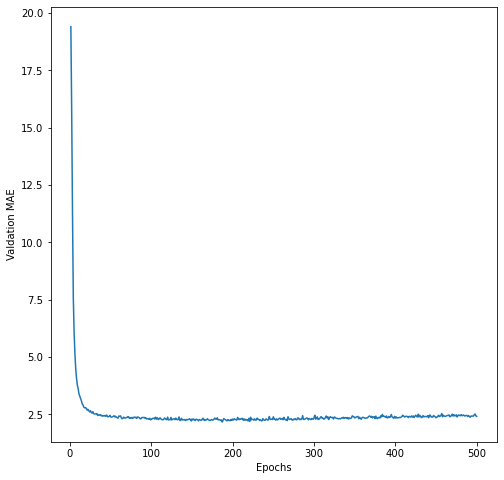

In [10]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Valdation MAE')
plt.show()

As it is right now, it's quite hard to read the plot since the first 10 epochs had very high validation MAE. So to make it more readable, let's ignore the first 10 epochs.

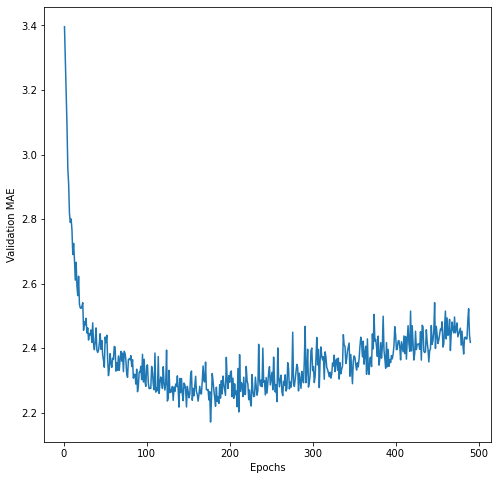

In [11]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

So as you can see, starting from epoch 140-190, the validation MAE starts to plateau and even overfit. So let's make a new model from scratch and train it for 180 epochs (we are not using K-fold cross-validation for this).

In [17]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=170, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

Epoch 1/170
 1/26 [>.............................] - ETA: 11s - loss: 362.8058 - mae: 18.2474

2022-04-11 03:18:08.958338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 9ms/step - loss: 504.8195 - mae: 20.4708
Epoch 2/170
26/26 [==============================] - 0s 8ms/step - loss: 325.4128 - mae: 15.7109
Epoch 3/170
26/26 [==============================] - 0s 7ms/step - loss: 154.5468 - mae: 9.9362
Epoch 4/170
26/26 [==============================] - 0s 8ms/step - loss: 73.7031 - mae: 6.3764
Epoch 5/170
26/26 [==============================] - 0s 8ms/step - loss: 47.0724 - mae: 5.0737
Epoch 6/170
26/26 [==============================] - 0s 10ms/step - loss: 34.6614 - mae: 4.2210
Epoch 7/170
26/26 [==============================] - 0s 10ms/step - loss: 27.2989 - mae: 3.7133
Epoch 8/170
26/26 [==============================] - 0s 10ms/step - loss: 23.0990 - mae: 3.3906
Epoch 9/170
26/26 [==============================] - 0s 9ms/step - loss: 20.6620 - mae: 3.2036
Epoch 10/170
26/26 [==============================] - 0s 9ms/step - loss: 18.6495 - mae: 3.0212
Epoch 11/170
26/26 [==============================] -

2022-04-11 03:18:53.725184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In the end, our model settled down around about 2,542, meaning our predictions are off by $2,542 on average. That's an improvement. If you have time, you can try different model to squeeze down the test error. For now, let's accept this result and move on the next part.

## Generating predictions on new data

For this problem, our model generate the median price of the house in thousands of dollars, instead of a singe discrete value.

In [18]:
predictions = model.predict(test_data)
print(predictions[0])

[9.776211]


2022-04-11 03:22:19.645918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The first house in the test set is predicted to have the price around $10,000.

## Wrapping up

Here’s what you should take away from this scalar regression example:

* Regression is done using different loss functions than we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.

* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).

* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.

* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.

* When little training data is available, it’s preferable to use a small model with few intermediate layers (typically only one or two), in order to avoid severe overfitting.